In [1]:
import os
from pathlib import Path
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, auc

from adad.utils import create_dir

In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent.parent
print(PATH_ROOT)

/home/lukec/workspace/applicabilityDomain


## Objective

- Create ROC plots per dataset per model;

In [3]:
CLASSIFIERS = ['KNeighborsClassifier', 'NNClassifier', 'RandomForestClassifier', 'SVC']
CLF_alias = ['KNN', 'NN', 'RF', 'SVM']
AD = ['DAIndexDelta', 
      'DAIndexGamma', 
      'DAIndexKappa', 
      'PCABoundingBox', 
      'ProbabilityClassifier', 
      'Magnet',
      'SklearnFeatureSqueezing', 
      'SklearnRegionBasedClassifier',
]
AD_alias = ['DM-δ',
            'DM-γ',
            'DM-κ',
            'BB',
            'Prob.',
            'Magnet',
            'FS',
            'RC'
]
AL = ['Magnet', 'FS', 'RC']
DATASETS = ['Ames', 'BBBP', 'Cancer', 'CYP1A2', 'hERG', 'HIV', 'Liver']
COLOURS = ['#882E72', '#1965B0', '#7BAFDE', '#4EB265', '#CAE0AB', '#F7F056', '#EE8026', '#DC050C']

In [4]:
def get_data_path(model, ad, dataset):
    """Return a full path of the ROC results;"""
    path_file = os.path.join(PATH_ROOT, 'results', f'{model}_{ad}', f'{dataset}_roc.csv')
    # print(os.path.join(PATH_ROOT, 'results', f'{model}_{ad}', f'{dataset}_roc.csv'))
    return path_file

# Test function
df = pd.read_csv(get_data_path(CLASSIFIERS[0], AD[0], DATASETS[0]))
df.head()

,cv1_fpr,cv1_tpr,cv2_fpr,cv2_tpr,cv3_fpr,cv3_tpr,cv4_fpr,cv4_tpr,cv5_fpr,cv5_tpr
0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1,0.00099,0.000000,0.000000,0.003236,0.000000,0.003636,0.000999,0.000000,0.00000,0.003559
2,0.00099,0.003425,0.002016,0.003236,0.001949,0.003636,0.000999,0.003333,0.00000,0.010676
3,0.00495,0.003425,0.002016,0.009709,0.001949,0.010909,0.002997,0.003333,0.00098,0.010676
4,0.00495,0.006849,0.004032,0.009709,0.002924,0.010909,0.002997,0.006667,0.00098,0.014235


In [5]:
def get_mean_tpr(clf, ad, dataset):
    """Get TPR on 5-fold CV on 1 dataset with 1 classifier and 1 AD method;"""
    mean_fpr = np.linspace(0, 1, 100)
    df = pd.read_csv(get_data_path(clf, ad, dataset))
    tpr = []
    # Results are saved as 5-fold CV, starts from 1 to 5;
    for i in range(1, 6):
        fold_fpr = df[f'cv{i}_fpr'].dropna().to_numpy()
        fold_tpr = df[f'cv{i}_tpr'].dropna().to_numpy()
        interp_tpr = np.interp(mean_fpr, fold_fpr, fold_tpr)
        interp_tpr[0] = 0.
        tpr.append(interp_tpr)

    mean_tpr = np.mean(tpr, axis=0)
    mean_tpr[-1] = 1.0
    mean_tpr = pd.Series(mean_tpr)
    return mean_tpr

# Test function
res = get_mean_tpr(CLASSIFIERS[0], AD[0], DATASETS[0])
res

0     0.000000
1     0.019244
2     0.035791
3     0.051066
4     0.075846
        ...   
95    0.980451
96    0.984066
97    0.987680
98    0.991295
99    1.000000
Length: 100, dtype: float64

In [6]:
def get_df_roc(clf, dataset):
    """Get a DataFrame that contains all AD method on 1 dataset and 1 classifier;""" 
    df_roc = pd.DataFrame({ 'fpr': np.linspace(0, 1, 100) })

    for i, (ad, ad_lbl) in enumerate(zip(AD, AD_alias)):
        # print(i, ad, ad_lbl)
        _tpr = res = get_mean_tpr(clf, ad, dataset)
        df_roc = pd.concat((df_roc, pd.DataFrame({ ad_lbl: _tpr })), axis=1)
    return df_roc

# Test function
df_roc = get_df_roc(CLASSIFIERS[0], DATASETS[0])
df_roc.head()

,fpr,DM-δ,DM-γ,DM-κ,BB,Prob.,Magnet,FS,RC
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.010101,0.019244,0.017036,0.022883,0.011099,0.025762,0.043132,0.089057,0.070202
2,0.020202,0.035791,0.042185,0.037495,0.022198,0.051525,0.080093,0.163377,0.112918
3,0.030303,0.051066,0.057237,0.056757,0.033296,0.077287,0.109274,0.213623,0.159961
4,0.040404,0.075846,0.071632,0.063039,0.044395,0.103049,0.136566,0.250469,0.196816


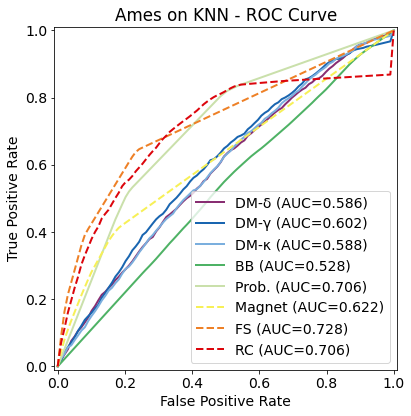

In [7]:
def plot_roc(clf, clf_alias, dataset, path_output, figsize=(6, 6), fontsize=14):
    plt.rc("figure", autolayout=True, figsize=figsize)
    plt.rcParams["font.size"] = fontsize

    fig, ax = plt.subplots()

    df_roc = get_df_roc(clf, dataset)
    for i, ad in enumerate(df_roc.columns[1:]):
        auc_score = auc(df_roc['fpr'], df_roc[ad])

        # Dashed lines for all advx. defenses
        ls = '--' if ad in AL else '-'

        display = RocCurveDisplay(fpr=df_roc['fpr'], tpr=df_roc[ad], roc_auc=auc_score)
        display.plot(ax=ax, alpha=1, lw=2, color=COLOURS[i], ls=ls, label=f"{ad} (AUC={auc_score:.3f})")

    ax.set_aspect('equal')
    ax.set(xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
    ax.legend(loc="lower right")
    ax.set_title(f'{dataset} on {clf_alias} - ROC Curve')
    plt.tight_layout()
    plt.savefig(path_output, dpi=300)


# Test function
clf = CLASSIFIERS[0]
clf_alias = CLF_alias[0]
dataset = DATASETS[0]
path_roc = os.path.join(PATH_ROOT, 'plot_results', 'ames_knn_roc.pdf')
plot_roc(clf, clf_alias, dataset, path_roc)
os.remove(path_roc)

/tmp/ipykernel_11751/2406945546.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


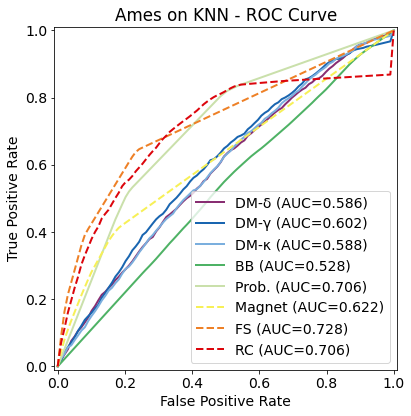

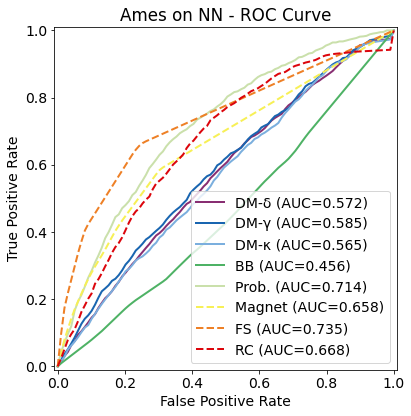

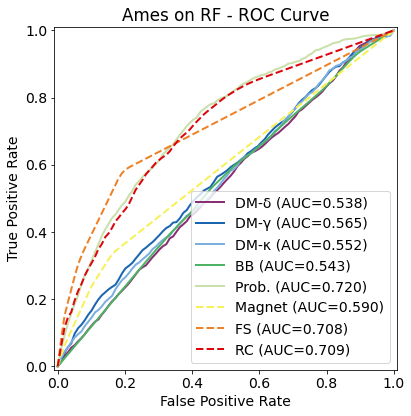

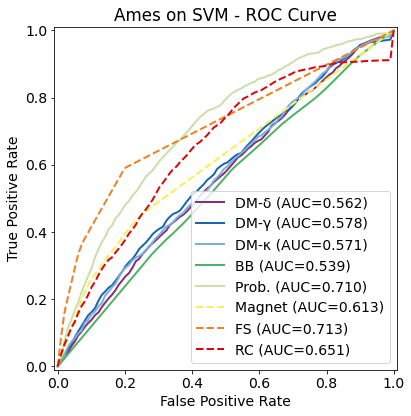

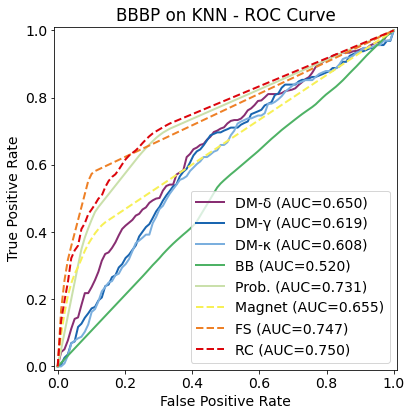

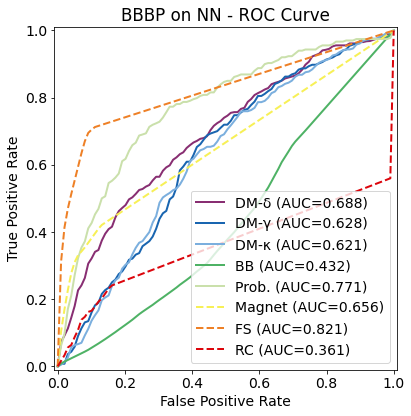

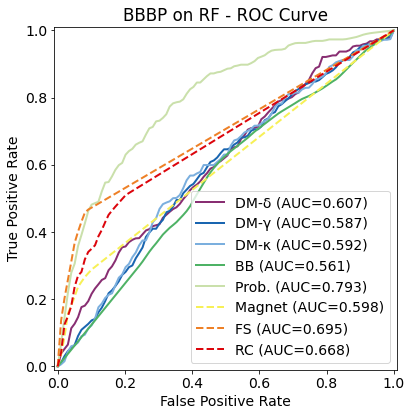

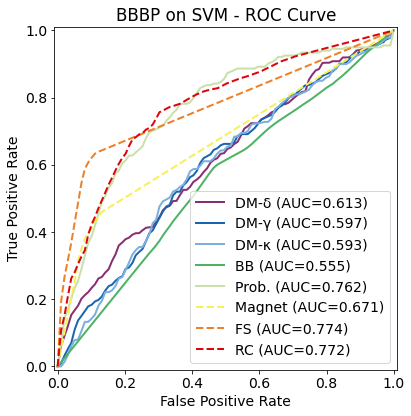

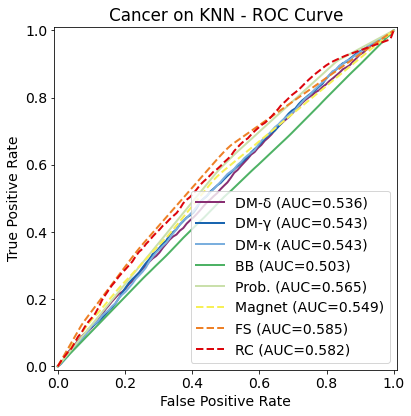

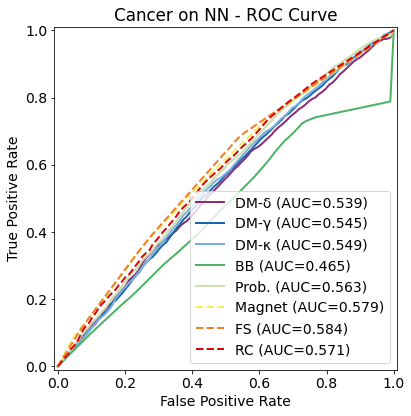

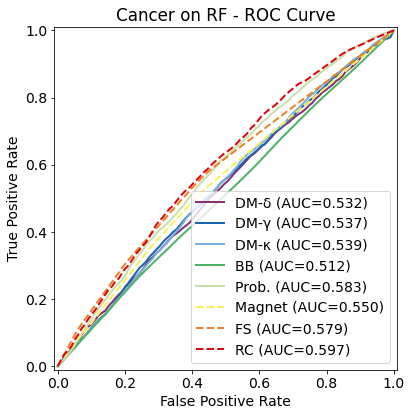

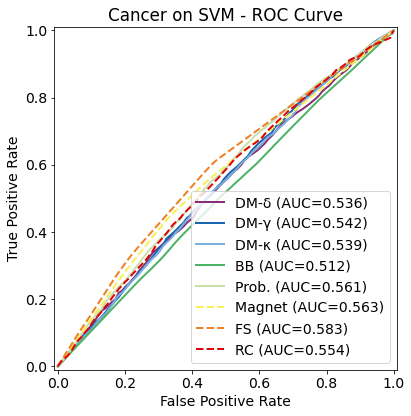

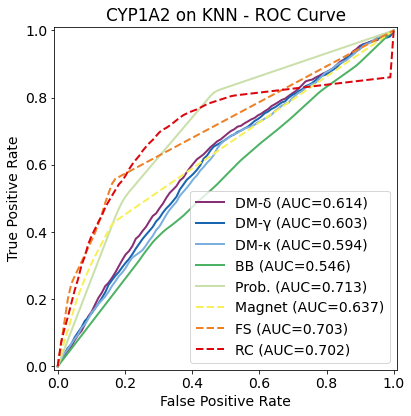

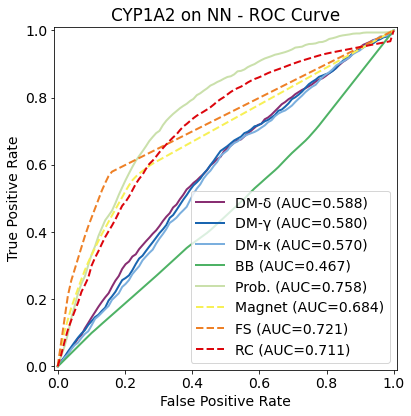

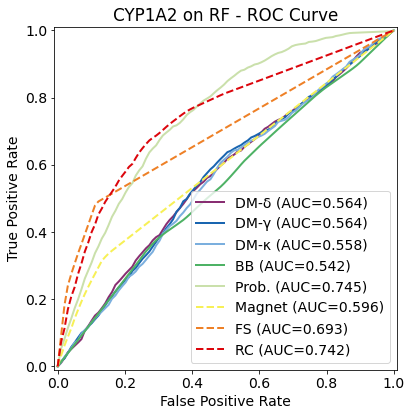

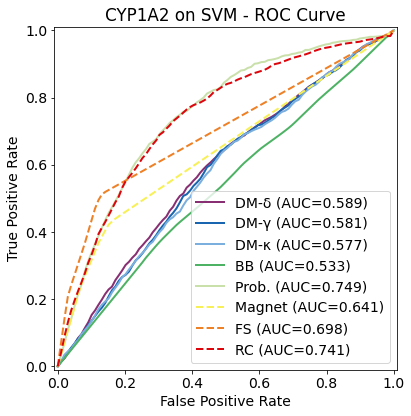

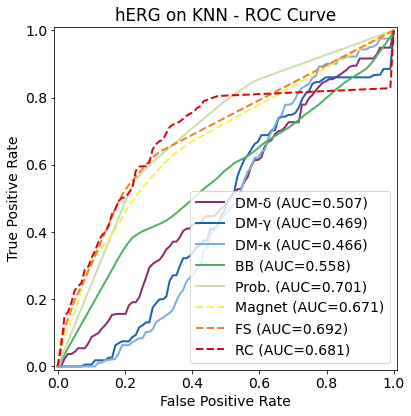

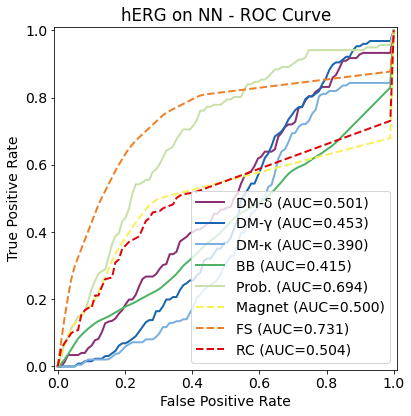

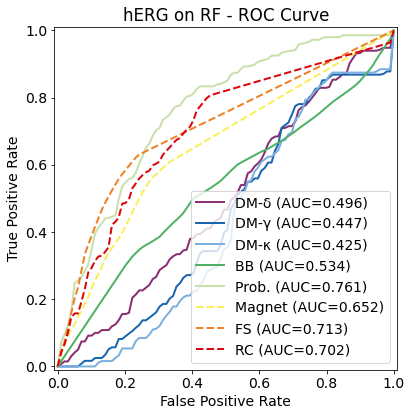

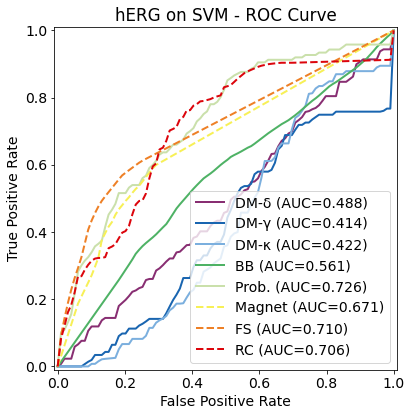

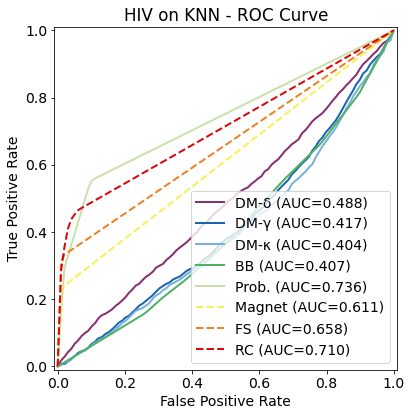

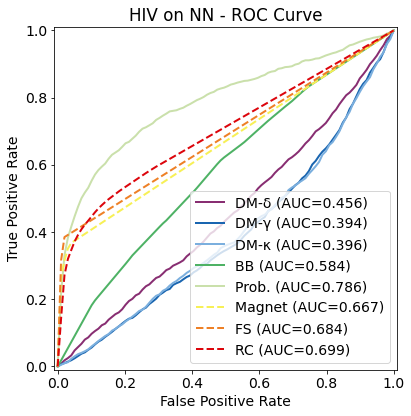

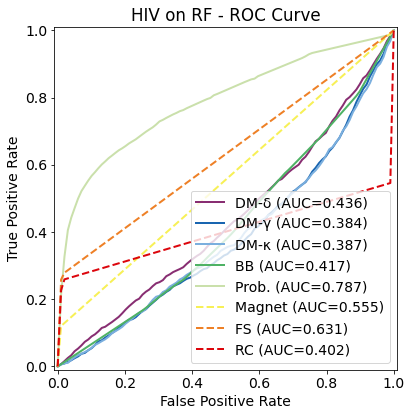

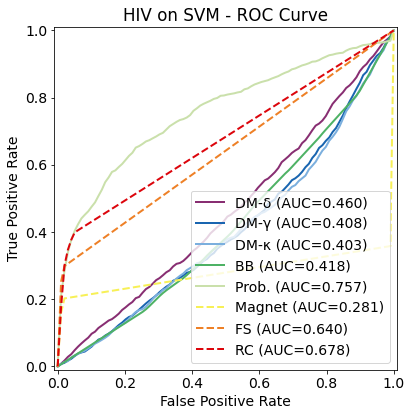

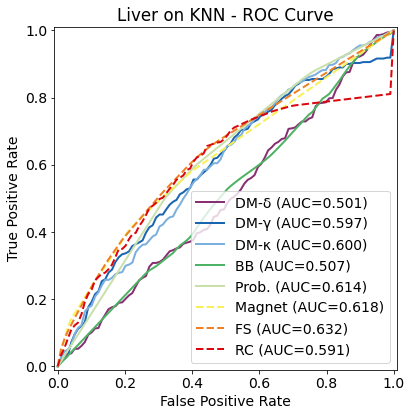

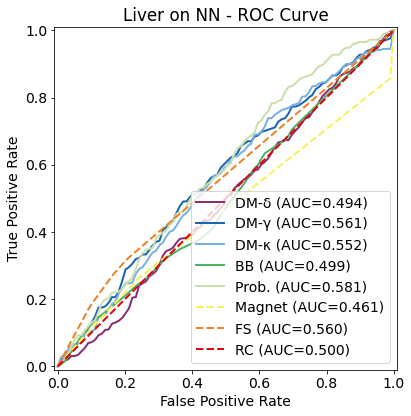

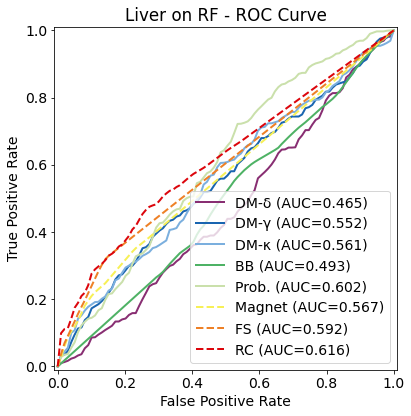

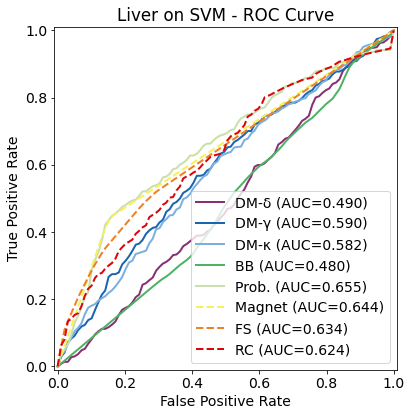

In [8]:
path_roc = Path(os.path.join(PATH_ROOT, 'plot_results', 'roc'))
for dataset in DATASETS:
    for clf, alias in zip(CLASSIFIERS, CLF_alias):
        plot_roc(clf, alias, dataset, path_roc / f'{dataset}_{alias}_roc.pdf')